In [1]:
ours2orig = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 254, 41, 42, 43, 44, 45,
46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85,
86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103,
104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 136, 138, 132,
133, 134, 135, 220, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 185, 186,
187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
233, 137, 234, 235, 236, 237, 238, 239, 240, 241, 250, 251, 255, 256, 257,
258, 259, 260, 261, 262, 263, 242, 243, 244, 245, 0, 1, 2, 3, 4, 5, 6, 7, 8,
9, 10, 11, 83, 84, 131, 139, 140, 141, 181, 182, 183, 184, 246, 247, 248,
249, 252, 253]

def vec2mat(v):
    a,b = np.triu_indices(264,1)
    m = np.zeros((264,264))
    m[a,b] = v
    return m+m.T

def remap(fc, roimap=ours2orig):
    fc = fc[roimap,:]
    fc = fc[:,roimap]
    return fc

print('Complete')

Complete


In [2]:
import pickle
import numpy as np

pncdir = '/home/anton/Documents/Tulane/Research/data-sav/anton/cohorts/PNC/'
lowrankdir = '/home/anton/Documents/Tulane/Research/Work/ContrastiveLearning/PNC/Top10/'
pncdemo = pickle.load(open(f'{pncdir}/demographics.pkl', 'rb'))

rest = []
nback = []
emoid = []
restmat = []
nbackmat = []
emoidmat = []
race = []
sex = []
age = []

a,b = np.triu_indices(264,1)

for sub in pncdemo['age_at_cnb']:
    try:
        ra = pncdemo['Race'][sub]
        ag = pncdemo['age_at_cnb'][sub]
        se = pncdemo['Sex'][sub]
        if ra not in ['AA', 'EA']:
            continue
        ra = ra == 'AA'
        se = se == 'M'
        r = np.load(f'{lowrankdir}/{sub}_task-resttop10_fc.npy')
        n = np.load(f'{lowrankdir}/{sub}_task-nbacktop10_fc.npy')
        e = np.load(f'{lowrankdir}/{sub}_task-emoidtop10_fc.npy')
        r = remap(vec2mat(r))
        n = remap(vec2mat(n))
        e = remap(vec2mat(e))
        race.append(ra)
        sex.append(se)
        age.append(ag)
        rest.append(r[a,b])
        nback.append(n[a,b])
        emoid.append(e[a,b])
        restmat.append(r)
        nbackmat.append(n)
        emoidmat.append(e)
    except:
        pass

rest = np.stack(rest)
nback = np.stack(nback)
emoid = np.stack(emoid)
restmat = np.stack(restmat)
nbackmat = np.stack(nbackmat)
emoidmat = np.stack(emoidmat)
race = np.array(race).astype('int')
sex = np.array(sex).astype('int')
age = np.array(age)

age = (age-np.mean(age))/np.std(age)

print([a.shape for a in [rest, nback, emoid, restmat, nbackmat, emoidmat, race, sex, age]])

[(1193, 34716), (1193, 34716), (1193, 34716), (1193, 264, 264), (1193, 264, 264), (1193, 264, 264), (1193,), (1193,), (1193,)]


In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def rmse(a, b, mean=torch.mean):
    return mean((a-b)**2)**0.5

def pretty(x):
    return f'{round(float(x), 4)}'

def mat2vec(x):
    nroi = x.shape[1]
    a,b = np.triu_indices(nroi,1)
    return x[:,a,b]

class FC2TS(nn.Module):
    def __init__(self, nroi, nt, ld):
        super(FC2TS, self).__init__()
        self.nroi = nroi
        self.nt = nt
        self.vecdim = int((nroi-1)*nroi/2)
        self.fc1 = nn.Linear(self.vecdim, ld).float().cuda()
        self.fc2 = nn.Linear(ld, nroi*nt).float().cuda()

    def unpack(self, packed):
        ts = packed.reshape(packed.shape[0], self.nroi, self.nt)
        return ts

    def ts2fc(self, ts, einsum=torch.einsum):
        xy = einsum('nat,nbt->nab', ts, ts)
        xx = einsum('nat,nat->na', ts, ts)
        xx1 = xx.unsqueeze(1)**0.5
        xx2 = xx.unsqueeze(2)**0.5
        rho = xy/xx1/xx2
        return rho, xx

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

fc2ts = FC2TS(264, 100, 1000)
optim = torch.optim.Adam(fc2ts.parameters(), lr=1e-5, weight_decay=0)

x = torch.from_numpy(np.concatenate([rest[:1000], nback[:1000]])).float().cuda()

nepochs = 2000
pperiod = 20

for e in range(nepochs):
    optim.zero_grad()
    zp = fc2ts(x)
    ts = fc2ts.unpack(zp)
    xhat, xx = fc2ts.ts2fc(ts)
    loss_recon = rmse(x, mat2vec(xhat))
    loss_recon.backward()
    optim.step()
    if e%pperiod == 0 or e == nepochs-1:
        print(f'{e} {pretty(loss_recon)}')

print('Complete')

0 0.3828
20 0.2995
40 0.2369
60 0.2148
80 0.201
100 0.1916
120 0.1846
140 0.1792
160 0.1748
180 0.1711
200 0.1681
220 0.1655
240 0.1631
260 0.1611
280 0.1594
300 0.1577
320 0.1564
340 0.155
360 0.1536
380 0.1524
400 0.1513
420 0.1502
440 0.1493
460 0.1484
480 0.1474
500 0.1467
520 0.1457
540 0.1452
560 0.1442
580 0.1441
600 0.1427
620 0.142
640 0.1413
660 0.1408
680 0.1402
700 0.1395
720 0.1395
740 0.1383
760 0.1378
780 0.1374
800 0.1369
820 0.1363
840 0.1357
860 0.1351
880 0.1346
900 0.1341
920 0.1336
940 0.1334
960 0.1327
980 0.1323
1000 0.1317
1020 0.1313
1040 0.1309
1060 0.1304
1080 0.1302
1100 0.1298
1120 0.1292


KeyboardInterrupt: 

In [54]:
with torch.no_grad():
    y = torch.from_numpy(emoid).float().cuda()
    zp = fc2ts(y)
    ts = fc2ts.unpack(zp)
    yhat, _ = fc2ts.ts2fc(ts)
    loss_recon = rmse(y, mat2vec(yhat))
    print(loss_recon)

tensor(0.1453, device='cuda:0')


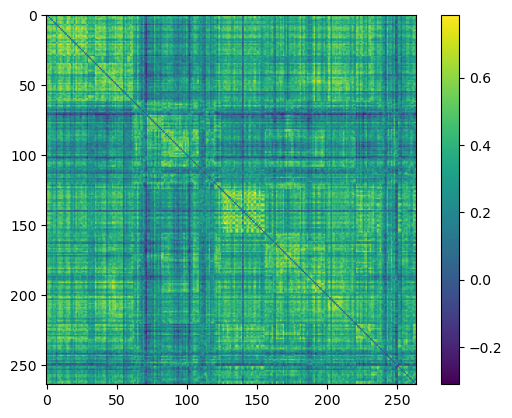

In [57]:
import matplotlib.pyplot as plt

test = np.corrcoef(ts[20].detach().cpu().numpy())
# test = yhat[20].detach().cpu().numpy()
test[test > 1] = 1
test = test * (1-np.eye(264))

# plt.imshow(emoidmat[20])
plt.imshow(test)
plt.colorbar()
plt.show()

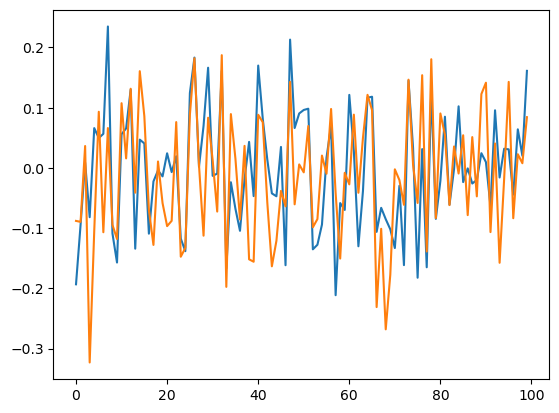

In [65]:
test = ts[20].detach().cpu().numpy()

plt.plot(test[4:6].T)
plt.show()